In [1]:
import os
os.chdir('..')

In [2]:
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob

In [3]:
plt.rcParams['font.family'] = 'DejaVu Serif'

In [4]:
helsinki_metadata = pd.read_csv('metadata/helsinki.csv', dtype={'test_id': str})
pisa_metadata = pd.read_csv('metadata/pisa.csv', dtype={'test_id': str})

In [5]:
pisa = glob('data/filtered/pisa/*.csv')
helsinki = glob('data/filtered/helsinki/*.csv')

In [6]:
node_index = {
    'neck': 0,
    'left_shoulder': 1, 'right_shoulder': 2,
    'left_hip': 3, 'right_hip': 4,
    'left_elbow': 5, 'right_elbow': 6,
    'left_wrist': 7, 'right_wrist': 8,
    'left_knee': 9, 'right_knee': 10,
    'left_ankle': 11, 'right_ankle': 12,
    'nose': 13,
    'left_eye': 14, 'right_eye': 15,
    'left_ear': 16, 'right_ear': 17,
}

edge_labels = [
    ('neck', 'nose'),
    ('neck', 'left_shoulder'),
    ('neck', 'right_shoulder'),
    ('left_shoulder', 'left_hip'),
    ('right_shoulder', 'right_hip'),
    ('left_shoulder', 'left_elbow'),
    ('right_shoulder', 'right_elbow'),
    ('right_elbow', 'right_wrist'),
    ('left_elbow', 'left_wrist'),
    ('left_hip', 'left_knee'),
    ('right_hip', 'right_knee'),
    ('left_knee', 'left_ankle'),
    ('right_knee', 'right_ankle'),
    ('nose', 'left_eye'),
    ('nose', 'right_eye'),
    ('left_eye', 'left_ear'),
    ('right_eye', 'right_ear'),
    ('left_wrist', 'right_wrist'),
    ('right_wrist', 'left_wrist'),
    ('left_ankle', 'right_ankle'),
    ('right_ankle', 'left_ankle'),
    ('left_ankle', 'left_wrist'),
    ('left_wrist', 'left_ankle'),
    ('right_ankle', 'right_wrist'),
    ('right_wrist', 'right_ankle'),
    ('left_ankle', 'right_wrist'),
    ('right_wrist', 'left_ankle'),
    ('right_ankle', 'left_wrist'),
    ('left_wrist', 'right_ankle'),
    
]

graph_bodyparts = list(node_index.keys())

In [7]:
rotation_nodes = {
    'neck': 0,
    'left_shoulder': 1, 'right_shoulder': 2,
    'left_hip': 3, 'right_hip': 4,
    'left_elbow': 5, 'right_elbow': 6,
    'left_wrist': 7, 'right_wrist': 8,
    'left_knee': 9, 'right_knee': 10,
    'left_ankle': 11, 'right_ankle': 12,
    'nose': 13,
    'left_eye': 14, 'right_eye': 15,
    'left_ear': 16, 'right_ear': 17,
}

rotation_edges = [
    ('neck', 'nose'),
    ('neck', 'left_shoulder'),
    ('neck', 'right_shoulder'),
    ('left_shoulder', 'left_hip'),
    ('right_shoulder', 'right_hip'),
    ('left_shoulder', 'left_elbow'),
    ('right_shoulder', 'right_elbow'),
    ('right_elbow', 'right_wrist'),
    ('left_elbow', 'left_wrist'),
    ('left_hip', 'left_knee'),
    ('right_hip', 'right_knee'),
    ('left_knee', 'left_ankle'),
    ('right_knee', 'right_ankle'),
    ('nose', 'left_eye'),
    ('nose', 'right_eye'),
    ('left_eye', 'left_ear'),
    ('right_eye', 'right_ear'),
]

In [8]:
def get_graph(row, node_index, edge_labels):
    G = nx.Graph()
    for bodypart in list(node_index.keys()):
        G.add_node(node_index[bodypart],
                   x=row[f'{bodypart}_x'],
                   y=row[f'{bodypart}_y'],
                   z=row[f'{bodypart}_z'],
                   label=bodypart
        )
    for label_0, label_1 in edge_labels:
        G.add_edge(node_index[label_0], node_index[label_1])
        
    return G

In [9]:
def plot_graph(row, node_index=node_index, edge_labels=edge_labels):
    G = get_graph(row, node_index, edge_labels)

    x = nx.get_node_attributes(G, 'x')
    y = nx.get_node_attributes(G, 'y')
    z = nx.get_node_attributes(G, 'z')

    pos = {}
    for node in G.nodes:
        pos[node] = (x[node], y[node], z[node])

    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    ax = plt.figure(figsize=(10,6)).add_subplot(projection='3d')

    # Plot the nodes - alpha is scaled by 'depth' automatically
    ax.scatter(*node_xyz.T, s=100, ec='w')

    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color='tab:gray')

    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.set_box_aspect(aspect=None, zoom=0.9)

    plt.tight_layout()
    plt.show()

In [10]:
def read_csv(f):
    df = pd.read_csv(f, usecols=lambda x: x != 'timestamp')

    # Add neck joint between shoulders
    for coord in ['x', 'y', 'z']:
        df[f'neck_{coord}'] = (df[f'left_shoulder_{coord}'] + df[f'right_shoulder_{coord}']) / 2
    
    # Add hip joint between left and righ hip
    for coord in ['x', 'y', 'z']:
        df[f'hip_{coord}'] = (df[f'left_hip_{coord}'] + df[f'right_hip_{coord}']) / 2
    
    return df

**Center method**

Subtract the neck_joint from all the joint coordinates. This translates the skeleton so that the neck joint is located at the origin.

In [11]:
def center_video(df):
    n_col = len(df.columns)
    n_joints = int(n_col / 3)
    
    # Translate so the neck joint is at the origin
    neck_joint = np.array(df[['neck_x', 'neck_y', 'neck_z']])
    for joint in range(n_joints):
        df.iloc[:, joint*3:joint*3+3] -= neck_joint

    return df

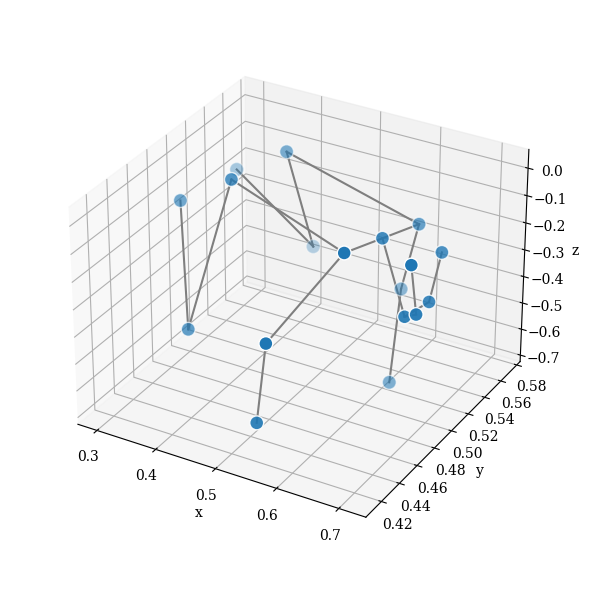

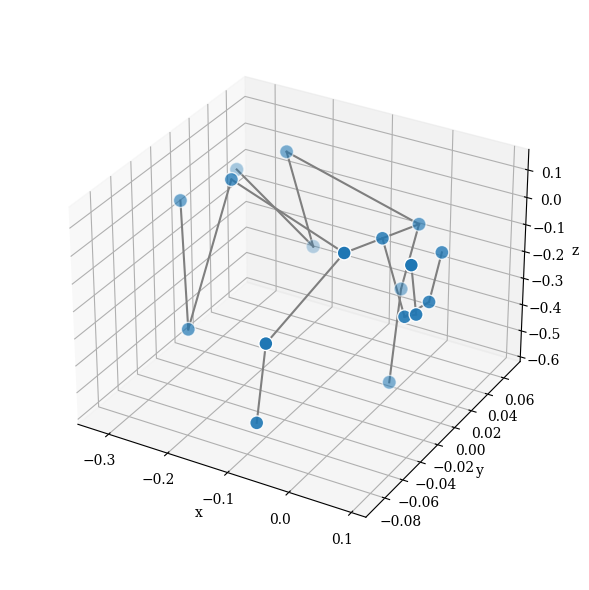

In [12]:
df = read_csv(pisa[12])
plot_graph(df.mean(), rotation_nodes, rotation_edges)
df = center_video(df)
plot_graph(df.mean(), rotation_nodes, rotation_edges)

In [13]:
def rotation_matrix_x(angle):
    return np.array([
        [1, 0, 0],
        [0, np.cos(angle), -np.sin(angle)],
        [0, np.sin(angle), np.cos(angle)]
    ])

def rotation_matrix_y(angle):
    return np.array([
        [np.cos(angle), 0, np.sin(angle)],
        [0, 1, 0],
        [-np.sin(angle), 0, np.cos(angle)]
    ])

def rotation_matrix_z(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])

def rotate_df(df, rot_matrix):
    n_col = len(df.columns)
    n_joints = int(n_col / 3)
    joint_coords = np.array(df.iloc[:, :]).T
    rot_matrices = np.kron(np.eye(n_joints), rot_matrix)
    joint_coords = np.dot(rot_matrices, joint_coords)
    df.iloc[:, :] = joint_coords.T
    return df

In [14]:
def calculate_vectors(df):
    neck_joint = np.array(df[['neck_x', 'neck_y', 'neck_z']])
    hip_joint = np.array(df[['hip_x', 'hip_y', 'hip_z']])
    right_hip = np.array(df[['right_hip_x', 'right_hip_y', 'right_hip_z']])
    left_hip = np.array(df[['left_hip_x', 'left_hip_y', 'left_hip_z']])
    right_shoulder = np.array(df[['right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z']])
    left_shoulder = np.array(df[['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z']])
    
    avg_spine = (hip_joint - neck_joint).mean(axis=0)
    hipline = (left_hip - right_hip)
    shoulderline = (left_shoulder - right_shoulder)
    avg_backline = ((hipline + shoulderline) / 2).mean(axis=0)
    
    return avg_spine, avg_backline

In [15]:
def plot_rotated_graph(row, node_index=node_index, edge_labels=edge_labels, save_dir=None):
    G = get_graph(row, node_index, edge_labels)

    x = nx.get_node_attributes(G, 'x')
    y = nx.get_node_attributes(G, 'y')
    z = nx.get_node_attributes(G, 'z')

    pos = {}
    for node in G.nodes:
        pos[node] = (x[node], y[node], z[node])

    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    ax = plt.figure().add_subplot(projection='3d')

    # Plot the nodes - alpha is scaled by 'depth' automatically
    ax.scatter(*node_xyz.T, s=100, ec='w')

    # Define the color and width for ankle-wrist edges
    special_edges = {('left_ankle', 'left_wrist'), ('right_ankle', 'right_wrist'),
                     ('left_wrist', 'left_ankle'), ('right_wrist', 'right_ankle'),
                     ('left_ankle', 'right_wrist'), ('right_wrist', 'left_ankle'),
                     ('right_ankle', 'left_wrist'), ('left_wrist', 'right_ankle'),
                     ('left_wrist', 'right_wrist'), ('left_ankle', 'right_ankle')}
    
    special_edges_indices = [(node_index[u], node_index[v]) for u, v in special_edges]

    for u, v in G.edges():
        color = 'tab:orange' if (u, v) in special_edges_indices or (v, u) in special_edges_indices else 'tab:gray'
        lw = 2 if (u, v) in special_edges_indices or (v, u) in special_edges_indices else 1.5
        ls = (0, (1, 1)) if (u, v) in special_edges_indices or (v, u) in special_edges_indices else '-'
        ax.plot(*np.array([pos[u], pos[v]]).T, color=color, ls=ls, lw=lw)

    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

In [16]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)
        
def plot_directed_edge(ax, start, end, color='k', linewidth=1.5, linestyle='-', alpha=1.0):
    arrow_prop_dict = dict(
        mutation_scale=15,
        arrowstyle='-|>',
        linestyle=linestyle,
        color=color,
        linewidth=linewidth,
        alpha=alpha
    )
    arrow = Arrow3D([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], **arrow_prop_dict)
    ax.add_artist(arrow)

def plot_rotation_graph(ax, row, node_index, edge_labels, avg_spine, avg_backline, arrow_base, arrow_scale, limb_edges=False):
    G = get_graph(row, node_index, edge_labels)

    x = nx.get_node_attributes(G, 'x')
    y = nx.get_node_attributes(G, 'y')
    z = nx.get_node_attributes(G, 'z')
    
    y_min, y_max = min(y.values()), max(y.values())
    z_min, z_max = min(z.values()), max(z.values())
    x_min, x_max = min(x.values()), max(x.values())

    # Calculate position dictionary
    pos = {node: (x_val, y_val, z_val) for node, (x_val, y_val, z_val) in zip(G.nodes, zip(x.values(), y.values(), z.values()))}

    # Plot nodes
    ax.scatter(*zip(*pos.values()), s=100, ec='w')

    # Plot edges
    if limb_edges:
        # Define the color and width for ankle-wrist edges
        special_edges = {('left_ankle', 'left_wrist'), ('right_ankle', 'right_wrist'),
                         ('left_wrist', 'left_ankle'), ('right_wrist', 'right_ankle'),
                         ('left_ankle', 'right_wrist'), ('right_wrist', 'left_ankle'),
                         ('right_ankle', 'left_wrist'), ('left_wrist', 'right_ankle'),
                         ('left_wrist', 'right_wrist'), ('left_ankle', 'right_ankle')}

        special_edges_indices = [(node_index[u], node_index[v]) for u, v in special_edges]

        for u, v in G.edges():
            color = 'tab:orange' if (u, v) in special_edges_indices or (v, u) in special_edges_indices else 'tab:gray'
            lw = 2 if (u, v) in special_edges_indices or (v, u) in special_edges_indices else 1.5
            ls = (0, (1, 1)) if (u, v) in special_edges_indices or (v, u) in special_edges_indices else '-'
            ax.plot(*np.array([pos[u], pos[v]]).T, color=color, ls=ls, lw=lw)
    else:
        for u, v in G.edges():
            ax.plot(*zip(*(pos[u], pos[v])), color='tab:gray', lw=1.5)
    
    # Define vector base
    vector_base = arrow_base

    # Adjust vector length
    l_spine = arrow_scale[0]
    l_back = arrow_scale[1]
    avg_spine_adjusted = avg_spine / np.linalg.norm(avg_spine) * l_spine
    avg_backline_adjusted = avg_backline / np.linalg.norm(avg_backline) * l_back

    # Calculate end points
    spine_end = vector_base + avg_spine_adjusted
    backline_end = vector_base + avg_backline_adjusted

    # Plot vectors
    plot_directed_edge(ax, vector_base, spine_end, color='tab:red', linewidth=1.5)
    plot_directed_edge(ax, vector_base, backline_end, color='tab:green', linewidth=1.5)

    # Set grid, labels, and aspect
    ax.xaxis.pane.set_facecolor('#FBFBFB')
    ax.yaxis.pane.set_facecolor('#F4F4F4')
    ax.zaxis.pane.set_facecolor('#FBFBFB')
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_zlabel('z', fontsize=12)
    
    ax.xaxis.pane.set_edgecolor('none')
    ax.yaxis.pane.set_edgecolor('none')
    ax.zaxis.pane.set_edgecolor('none')
    
    if round(y_max, 1) - round(y_min, 1) < 1:
        ax.set_yticks(np.arange(round(y_min, 1), round(y_max, 1) + 0.1, 0.1))
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.grid(True)
    grid_color = '#DCDCDC'
    
    ax.xaxis._axinfo['grid'].update(color=grid_color, linestyle='-')
    ax.yaxis._axinfo['grid'].update(color=grid_color, linestyle='-')
    ax.zaxis._axinfo['grid'].update(color=grid_color, linestyle='-')

    
def rotate_video(df, save_dir=None):
    fig = plt.figure(figsize=(20, 5))
    avg_spine, avg_backline = calculate_vectors(df)
    
    # 1. Plot the original graph
    ax1 = fig.add_subplot(1, 4, 1, projection='3d')
    arrow_base = [0.4, 0.47, 0.45]
    arrow_scale = [0.15, 0.13]
    plot_rotation_graph(ax1, df.mean(), rotation_nodes, rotation_edges, avg_spine, avg_backline, arrow_base, arrow_scale)
    ax1.set_title('Original infant graph', fontsize=18)
    
    # Center the video for rotation
    df = center_video(df)
    
    # 2. Rotation around Z-axis
    avg_spine_xy = np.array([avg_spine[0], avg_spine[1], 0])
    cosine_angle_z = np.dot([0, 1, 0], avg_spine) / (np.linalg.norm([0, 1, 0]) * np.linalg.norm(avg_spine_xy))
    angle_z = np.arccos(cosine_angle_z)
    if avg_spine[0] < 0:
        angle_z = -angle_z

    rot_matrix_z = rotation_matrix_z(angle_z)
    df_rot_z = rotate_df(df, rot_matrix_z)
    avg_spine_z, avg_backline_z = calculate_vectors(df_rot_z)
    
    ax2 = fig.add_subplot(1, 4, 2, projection='3d')
    arrow_base = [-0.37, 0.47, 0.34]
    arrow_scale = [0.19, 0.1]
    plot_rotation_graph(ax2, df_rot_z.mean(), rotation_nodes, rotation_edges, avg_spine_z, avg_backline_z, arrow_base, arrow_scale)
    ax2.set_title(r'Rotated around $z$', fontsize=18)

    # 3. Rotation around Z and X axes
    avg_spine_yz = np.array([0, avg_spine_z[1], avg_spine_z[2]])
    cosine_angle_x = np.dot([0, 1, 0], avg_spine_yz) / (np.linalg.norm([0, 1, 0]) * np.linalg.norm(avg_spine_yz))
    angle_x = np.arccos(cosine_angle_x)
    if avg_spine_z[2] > 0:
        angle_x = -angle_x

    rot_matrix_x = rotation_matrix_x(angle_x)
    df_rot_zx = rotate_df(df_rot_z, rot_matrix_x)
    avg_spine_zx, avg_backline_zx = calculate_vectors(df_rot_zx)
    
    ax3 = fig.add_subplot(1, 4, 3, projection='3d')
    arrow_base = [-0.24, 0.7, 0.135]
    arrow_scale = [0.35, 0.1]
    plot_rotation_graph(ax3, df_rot_zx.mean(), rotation_nodes, rotation_edges, avg_spine_zx, avg_backline_zx, arrow_base, arrow_scale)
    ax3.set_title(r'Rotated around $z$ and $x$', fontsize=18)

    # 4. Rotation around Z, X, and Y axes
    avg_backline_xz = np.array([avg_backline_zx[0], 0, avg_backline_zx[2]])
    cosine_angle_y = np.dot([1, 0, 0], avg_backline_xz) / (np.linalg.norm([1, 0, 0]) * np.linalg.norm(avg_backline_xz))
    angle_y = np.arccos(cosine_angle_y)
    if avg_backline_zx[2] < 0:
        angle_y = -angle_y

    rot_matrix_y = rotation_matrix_y(angle_y)
    df_rot_zxy = rotate_df(df_rot_zx, rot_matrix_y)
    avg_spine_zxy, avg_backline_zxy = calculate_vectors(df_rot_zxy)
    
    ax4 = fig.add_subplot(1, 4, 4, projection='3d')
    arrow_base = [-0.24, 0.7, 0.135]
    arrow_scale = [0.35, 0.1]
    plot_rotation_graph(ax4, df_rot_zxy.mean(), rotation_nodes, rotation_edges, avg_spine_zxy, avg_backline_zxy, arrow_base, arrow_scale, limb_edges=True)
    ax4.set_title(r'Rotated around $z$, $x$, and $y$', fontsize=18)
    
    ax1.set_box_aspect(None, zoom=0.9)
    ax2.set_box_aspect(None, zoom=0.9)
    ax3.set_box_aspect(None, zoom=0.9)
    ax4.set_box_aspect(None, zoom=0.9)
    
    plt.tight_layout()
    
    if save_dir:
        for ext in ['png', 'pdf', 'eps']:
            plt.savefig(os.path.join(save_dir, f'rotations.{ext}'), dpi=300, bbox_inches='tight')

    plt.show()

    return df_rot_zxy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


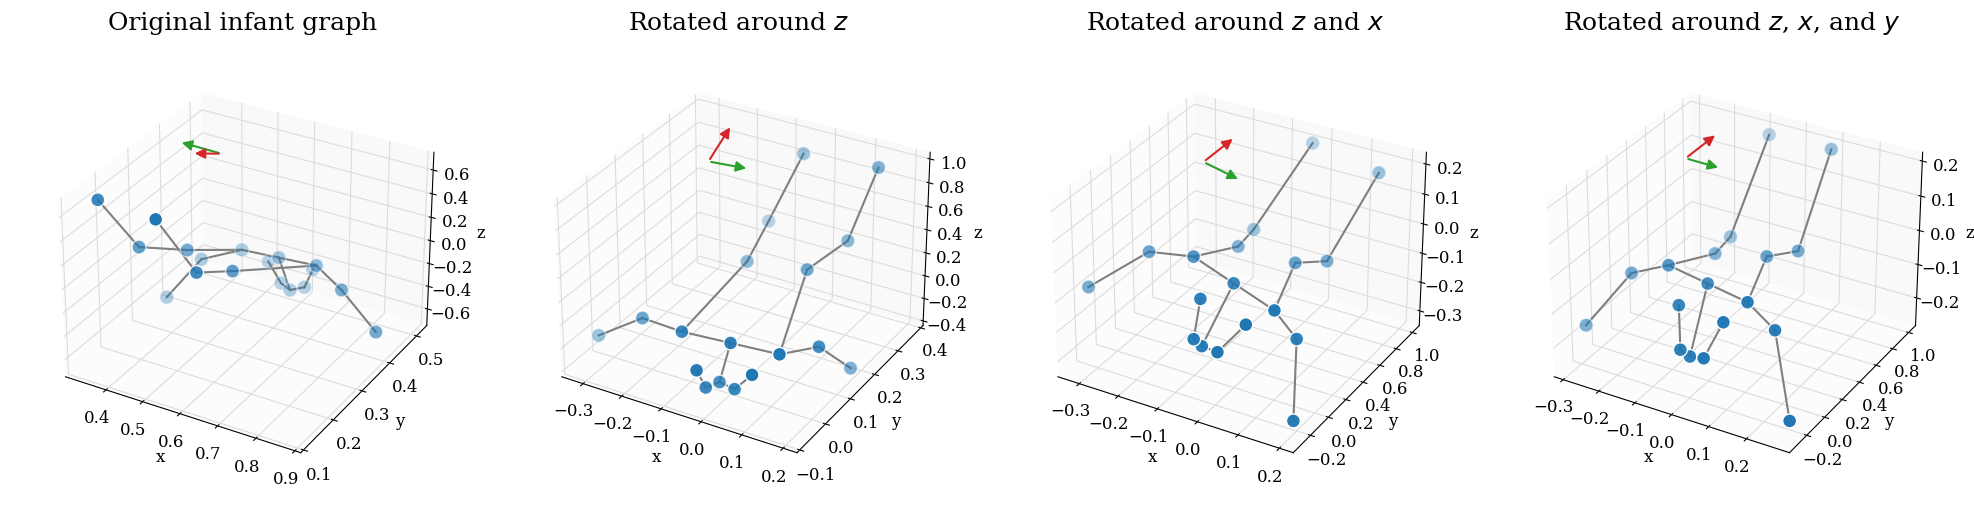

In [17]:
df = read_csv(helsinki[0])
df = rotate_video(df, save_dir='figures')

## Rotation method

### Rotation around the z-axis

$$
R_z(\theta) = 
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
$$

The rotation angle, $\theta$, is determined by the cosine of the angle between the average spine's xy-projection and the y-axis:

$$
\cos(\theta) = \frac{\textbf{s}_{xy} \cdot \textbf{j}}{||\textbf{s}_{xy}|| ||\textbf{j}||}
$$

where:

$$
\textbf{s}_{xy} = [s_x, s_y, 0]
$$
$$
\textbf{j} = [0, 1, 0]
$$

The angle $\theta$ is then:
$$
\theta = \arccos(\cos(\theta))
$$

If the x-component of the average spine is negative, $\theta$ is negated.

After this rotation is applied, the joint coordinates are updated, and the average spine vector's position and orientation are recalculated.

$$J' = R_z(\theta) J$$

where $J'$ mdenotes the rotated joint coordinates and $J$ represents the original joint coordinates

### Rotation around the x-axis

After the z-rotation, an x-axis rotation is performed to make the average spine vector parallel to the y-axis.
$$
R_x(\phi) = \left[ \begin{array}{ccc}
1 & 0 & 0 \\
0 & \cos(\phi) & -\sin(\phi) \\
0 & \sin(\phi) & \cos(\phi) \\
\end{array} \right]
$$
To determine the rotation angle $\phi$, is determined by the cosine of the angle between the average spine's yz-projection and the y-axis:

$$
\cos(\phi) = \frac{\textbf{s}_{yz} \cdot \textbf{j}}{||\textbf{s}|| ||\textbf{j}||}
$$

where:

$$
\textbf{s}_{yz} = [0, s_y, s_z]
$$
$$
\textbf{j} = [0, 1, 0]
$$

The angle $\phi$ is then:
$$
\phi = \arccos(\cos(\phi))
$$

If the z-component of the average spine vector is positive, $\phi$ is negated.

After this rotation is applied, the joint coordinates are updated again, resulting in the final aligned pose.

$$J'' = R_x(\phi) J'$$

### Rotation around the y-axis

Once the average spine vector is aligned with the y-axis, a rotation around the y-axis is performed to align the backline (average of the hipline and shoulder line) to face forward in the x-axis.

$$
R_y(\psi) = 
\begin{bmatrix}
\cos(\psi) & 0 & \sin(\psi) \\
0 & 1 & 0 \\
-\sin(\psi) & 0 & \cos(\psi) \\
\end{bmatrix}
$$

The rotation angle, $\psi$, is determined by the cosine of the angle between the average backline's xz-projection and the x-axis:

$$
\cos(\psi) = \frac{\textbf{b}_{xz} \cdot \textbf{i}}{||\textbf{b}_{xz}|| ||\textbf{i}||}
$$

where:

$$
\textbf{b}_{xz} = [b_x, 0, b_z]
$$
$$
\textbf{i} = [1, 0, 0]
$$

The angle $\psi$ is then:
$$
\psi = \arccos(\cos(\psi))
$$

If the z-component of the average backline is negative, $\psi$ is negated.

Finally, the rotation is applied to the joint coordinates:
$$
J''' = R_y(\psi) J''
$$

This results in the skeleton being aligned in the desired orientation.

## Rotate data and collect angle stats

In [17]:
def rotate_video(df):
    angles_z = []
    angles_x = []
    angles_y = []
    
    # Rotation around z-axis
    neck_joint = np.array(df[['neck_x', 'neck_y', 'neck_z']])
    hip_joint = np.array(df[['hip_x', 'hip_y', 'hip_z']])
    avg_spine = (hip_joint - neck_joint).mean(axis=0)
    
    avg_spine_xy = np.array([avg_spine[0], avg_spine[1], 0])
    cosine_angle_z = np.dot([0, 1, 0], avg_spine) / (np.linalg.norm([0, 1, 0]) * np.linalg.norm(avg_spine_xy))
    angle_z = np.arccos(cosine_angle_z)
    if avg_spine[0] < 0:
        angle_z = -angle_z
    
    rot_matrix = rotation_matrix_z(angle_z)
    
    df = rotate_df(df, rot_matrix)
    
    for i in range(len(df)):
        neck_joint = np.array(df[['neck_x', 'neck_y', 'neck_z']])
        hip_joint = np.array(df[['hip_x', 'hip_y', 'hip_z']])
        spine_vec = hip_joint[i] - neck_joint[i]
        
        spine_xy = np.array([avg_spine[0], avg_spine[1], 0])
        cosine_angle_z = np.dot([0, 1, 0], spine_vec) / (np.linalg.norm([0, 1, 0]) * np.linalg.norm(spine_xy))
        angle_z = np.arccos(cosine_angle_z)
        if avg_spine[0] < 0:
            angle_z = -angle_z
        
        angles_z.append(np.degrees(angle_z))
    
    # Rotation around x-axis
    neck_joint = np.array(df[['neck_x', 'neck_y', 'neck_z']])
    hip_joint = np.array(df[['hip_x', 'hip_y', 'hip_z']])
    avg_spine = (hip_joint - neck_joint).mean(axis=0)
    
    avg_spine_yz = np.array([0, avg_spine[1], avg_spine[2]])
    cosine_angle_x = np.dot([0, 1, 0], avg_spine_yz) / (np.linalg.norm([0, 1, 0]) * np.linalg.norm(avg_spine_yz))
    angle_x = np.arccos(cosine_angle_x)
    if avg_spine[2] > 0:
        angle_x = -angle_x
        
    rot_matrix = rotation_matrix_x(angle_x)
    
    df = rotate_df(df, rot_matrix)
    
    for i in range(len(df)):
        neck_joint = np.array(df[['neck_x', 'neck_y', 'neck_z']])
        hip_joint = np.array(df[['hip_x', 'hip_y', 'hip_z']])
        spine_vec = hip_joint[i] - neck_joint[i]
        
        spine_yz = np.array([0, spine_vec[1], spine_vec[2]])
        cosine_angle_x = np.dot([0, 1, 0], spine_yz) / (np.linalg.norm([0, 1, 0]) * np.linalg.norm(spine_yz))
        angle_x = np.arccos(cosine_angle_x)
        
        if spine_vec[2] > 0:
            angle_x = -angle_x
        
        angles_x.append(np.degrees(angle_x))
    
    # Rotation around y-axis
    right_hip = np.array(df[['right_hip_x', 'right_hip_y', 'right_hip_z']])
    left_hip = np.array(df[['left_hip_x', 'left_hip_y', 'left_hip_z']])
    hipline = (left_hip - right_hip)
    
    right_shoulder = np.array(df[['right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z']])
    left_shoulder = np.array(df[['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z']])
    shoulderline = (left_shoulder - right_shoulder)
    
    avg_backline = ((hipline + shoulderline) / 2).mean(axis=0)

    avg_backline_xz = np.array([avg_backline[0], 0, avg_backline[2]])
    cosine_angle_y = np.dot([1, 0, 0], avg_backline_xz) / (np.linalg.norm([1, 0, 0]) * np.linalg.norm(avg_backline_xz))
    angle_y = np.arccos(cosine_angle_y)
    if avg_backline[2] < 0:
        angle_y = -angle_y
    
    rot_matrix = rotation_matrix_y(angle_y)
    
    df = rotate_df(df, rot_matrix)
    
    for i in range(len(df)):
        right_hip = np.array(df[['right_hip_x', 'right_hip_y', 'right_hip_z']])
        left_hip = np.array(df[['left_hip_x', 'left_hip_y', 'left_hip_z']])

        right_shoulder = np.array(df[['right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z']])
        left_shoulder = np.array(df[['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z']])
        
        hipline = (left_hip[i] - right_hip[i])
        shoulderline = (left_shoulder[i] - right_shoulder[i])
        
        backline = (hipline + shoulderline) / 2
        
        backline_xz = np.array([backline[0], 0, backline[2]])
        cosine_angle_y = np.dot([1, 0, 0], backline_xz) / (np.linalg.norm([1, 0, 0]) * np.linalg.norm(backline_xz))
        angle_y = np.arccos(cosine_angle_y)
        if backline[2] < 0:
            angle_y = -angle_y
        
        angles_y.append(np.degrees(angle_y))

    return df, angles_z, angles_x, angles_y

In [18]:
def preprocess_dataset(flist):
    all_angles_z = []
    all_angles_x = []
    all_angles_y = []
    dfs = []
    
    for f in tqdm(flist):
        df = read_csv(f)
        df = center_video(df)
        df, angles_z, angles_x, angles_y = rotate_video(df)
        
        all_angles_z.extend(angles_z)
        all_angles_x.extend(angles_x)
        all_angles_y.extend(angles_y)
        
        dfs.append(df.mean())
    
    return pd.concat(dfs, axis=1).T, all_angles_z, all_angles_x, all_angles_y

In [19]:
helsinki_df, helsinki_angles_z, helsinki_angles_x, helsinki_angles_y = preprocess_dataset(helsinki)

  0%|          | 0/850 [00:00<?, ?it/s]

/tmp/dholmber/19592614/ipykernel_1091902/1143660122.py:28: RuntimeWarning: invalid value encountered in arccos
  angle_z = np.arccos(cosine_angle_z)
/tmp/dholmber/19592614/ipykernel_1091902/1143660122.py:55: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle_x = np.dot([0, 1, 0], spine_yz) / (np.linalg.norm([0, 1, 0]) * np.linalg.norm(spine_yz))
/tmp/dholmber/19592614/ipykernel_1091902/1143660122.py:97: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle_y = np.dot([1, 0, 0], backline_xz) / (np.linalg.norm([1, 0, 0]) * np.linalg.norm(backline_xz))


In [20]:
pisa_df, pisa_angles_z, pisa_angles_x, pisa_angles_y = preprocess_dataset(pisa)

  0%|          | 0/1040 [00:00<?, ?it/s]

/tmp/dholmber/19592614/ipykernel_1091902/1143660122.py:28: RuntimeWarning: invalid value encountered in arccos
  angle_z = np.arccos(cosine_angle_z)


data/filtered/helsinki/v63_1_9.csv


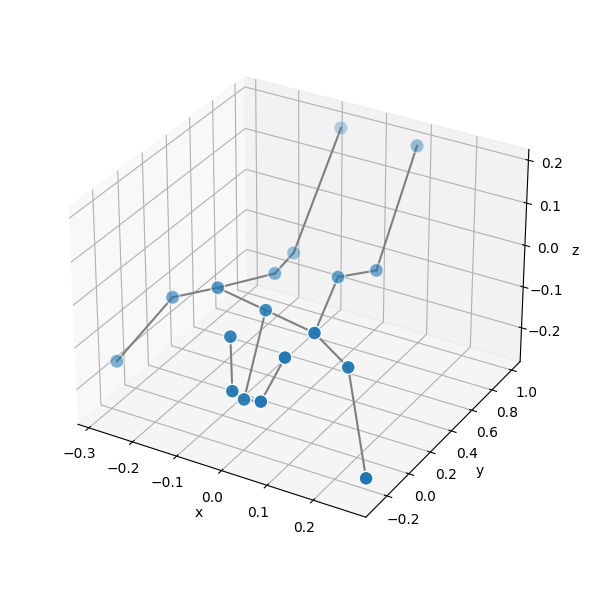

data/filtered/helsinki/v30_5_5.csv


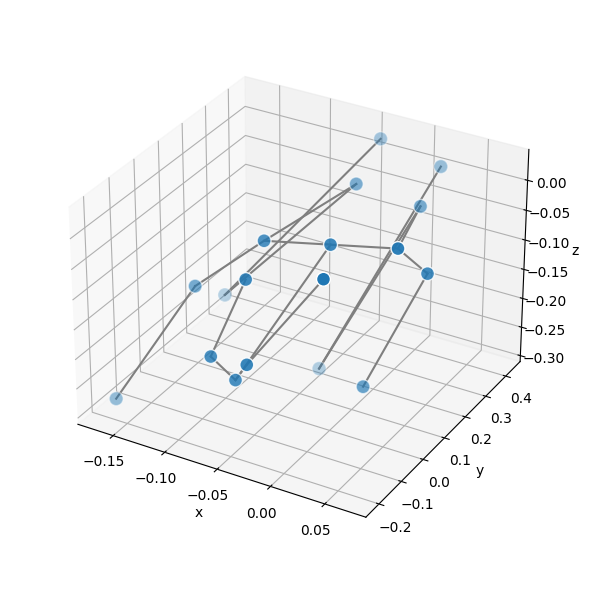

data/filtered/helsinki/vv75_3_1.csv


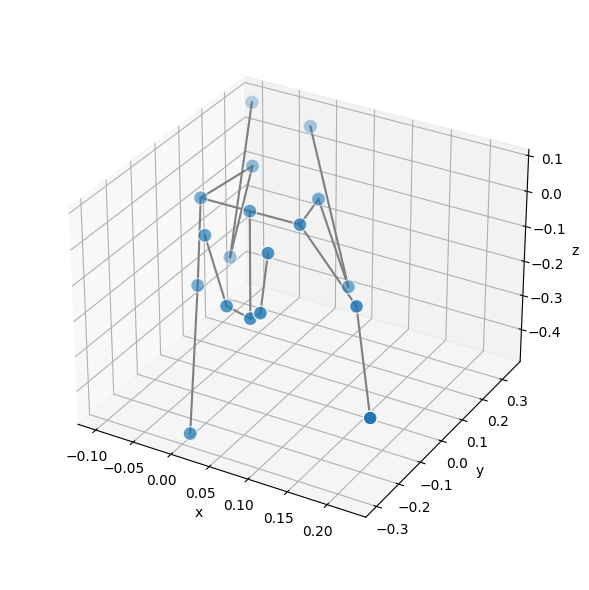

data/filtered/helsinki/v78_1_1.csv


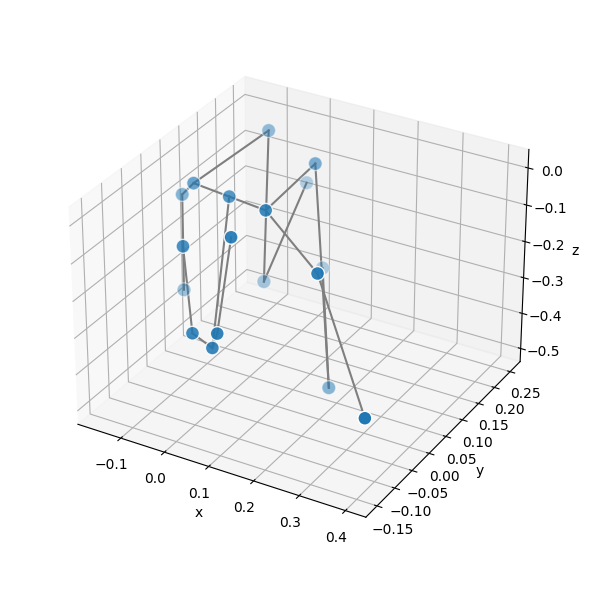

data/filtered/helsinki/v72_1_10.csv


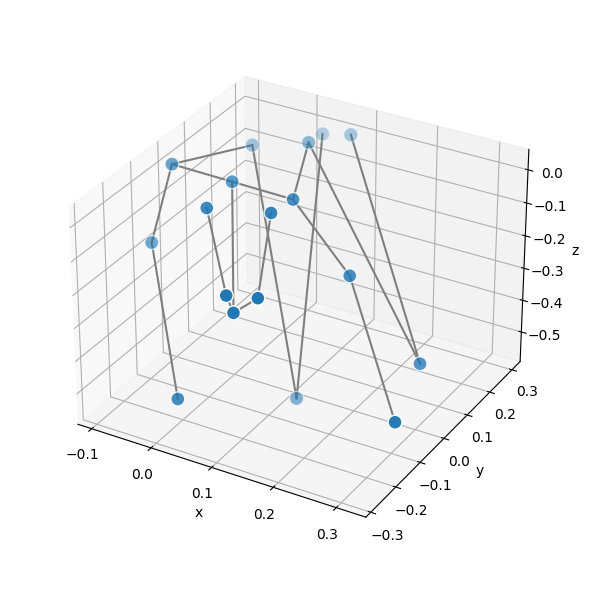

data/filtered/helsinki/v57_1_7.csv


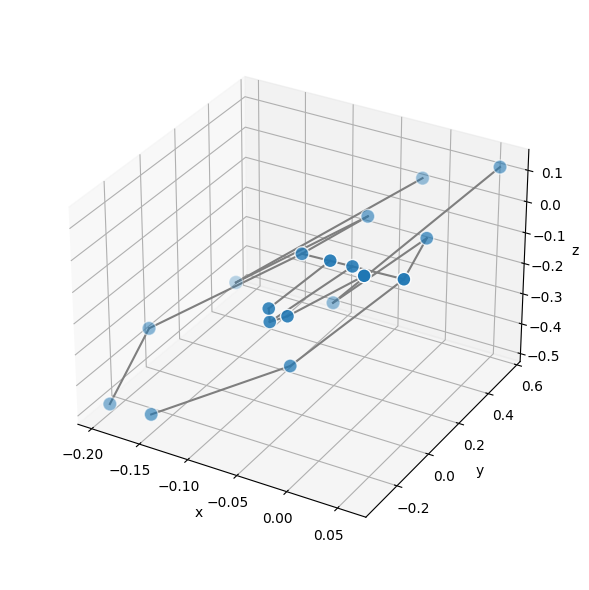

In [21]:
for i, row in helsinki_df.iterrows():
    print(helsinki[i])
    plot_graph(row, rotation_nodes, rotation_edges)
    if i==5:
        break

data/filtered/pisa/0078_2_7.csv


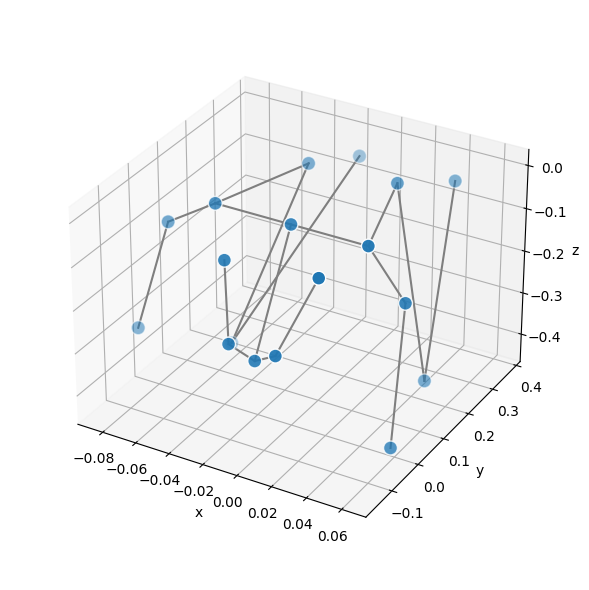

data/filtered/pisa/0028_1_9.csv


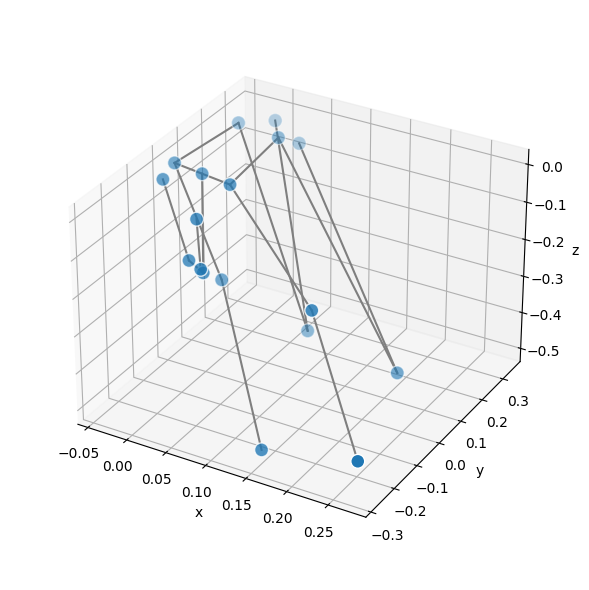

data/filtered/pisa/0089_2_7.csv


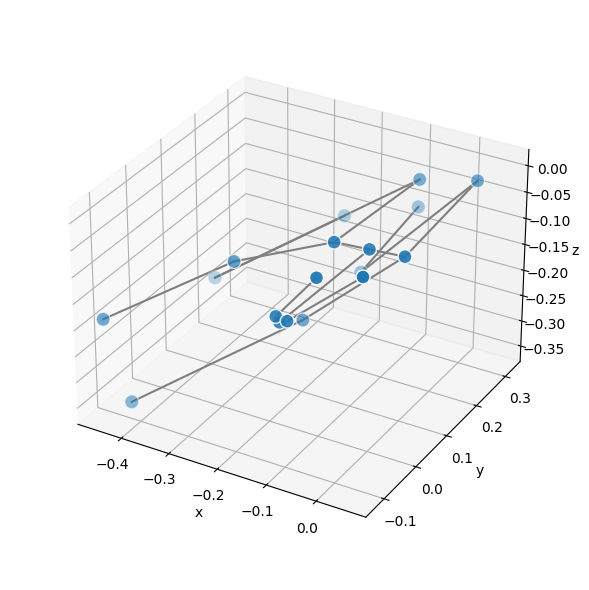

data/filtered/pisa/0119_2_0.csv


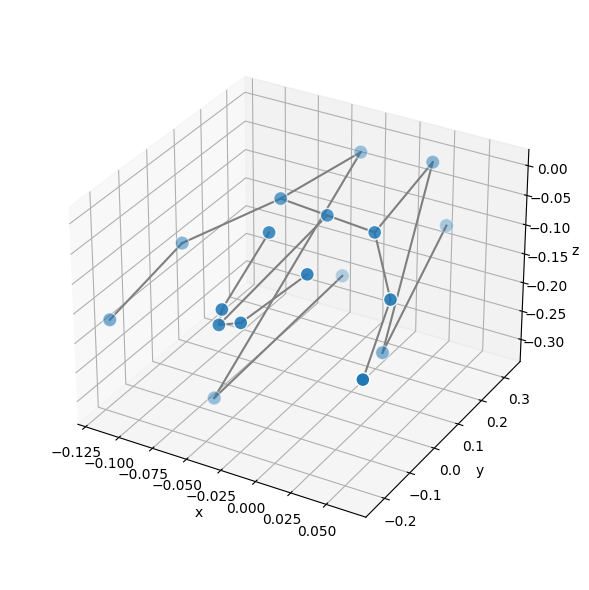

data/filtered/pisa/0015_1_1.csv


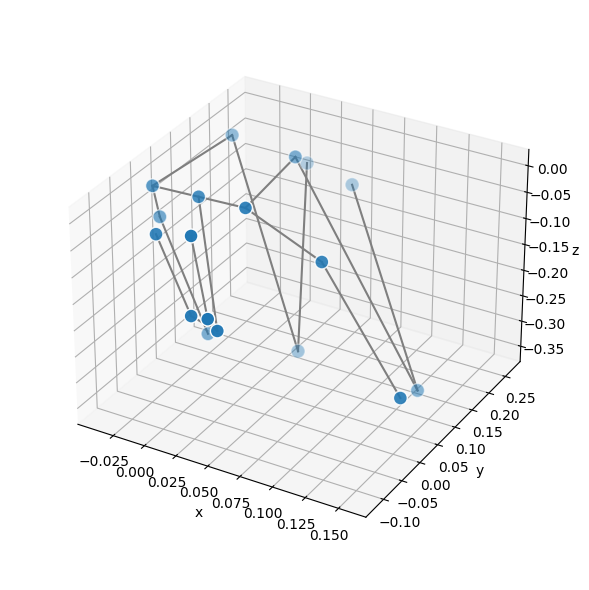

data/filtered/pisa/0009_2_1.csv


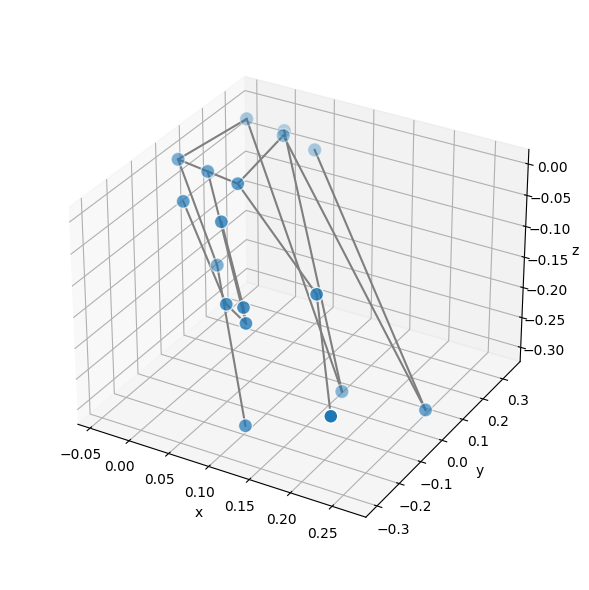

In [22]:
for i, row in pisa_df.iterrows():
    print(pisa[i])
    plot_graph(row, rotation_nodes, rotation_edges)
    if i==5:
        break

## Plot rotation deviation within videos

In [23]:
def plot_histograms(helsinki_angles, pisa_angles, title):
    # Plot the histograms
    plt.hist(helsinki_angles, bins=20, alpha=0.5, label='Helsinki', color='blue')
    plt.hist(pisa_angles, bins=20, alpha=0.5, label='Pisa', color='red')

    # Plot vertical lines for the means
    plt.axvline(np.nanmean(helsinki_angles), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.nanmean(pisa_angles), color='red', linestyle='dashed', linewidth=1)

    # Compute and plot medians
    median_helsinki = np.nanmedian(helsinki_angles)
    median_pisa = np.nanmedian(pisa_angles)
    plt.axvline(median_helsinki, color='blue', linestyle='solid', linewidth=1)
    plt.axvline(median_pisa, color='red', linestyle='solid', linewidth=1)

    # Compute and plot 25th and 75th quartiles
    q1_helsinki, q3_helsinki = np.nanpercentile(helsinki_angles, [25, 75])
    q1_pisa, q3_pisa = np.nanpercentile(pisa_angles, [25, 75])
    plt.axvline(q1_helsinki, color='blue', linestyle='dotted', linewidth=1)
    plt.axvline(q3_helsinki, color='blue', linestyle='dotted', linewidth=1)
    plt.axvline(q1_pisa, color='red', linestyle='dotted', linewidth=1)
    plt.axvline(q3_pisa, color='red', linestyle='dotted', linewidth=1)

    # Add labels and title
    plt.title(title)
    plt.xlabel(f'Degrees')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')

    # Print the median and quartile values
    print(f"Helsinki Median: {median_helsinki:.2f}, Q1: {q1_helsinki:.2f}, Q3: {q3_helsinki:.2f}")
    print(f"Pisa Median: {median_pisa:.2f}, Q1: {q1_pisa:.2f}, Q3: {q3_pisa:.2f}")

    plt.show()

Helsinki Median: 5.17, Q1: -10.26, Q3: 12.76
Pisa Median: -12.15, Q1: -17.42, Q3: -7.83


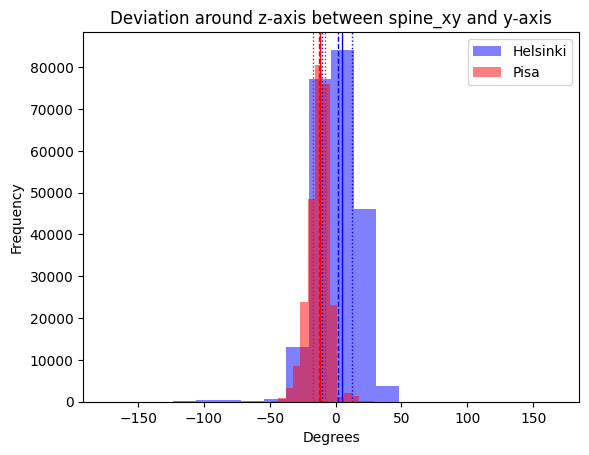

In [24]:
plot_histograms(helsinki_angles_z, pisa_angles_z, title='Deviation around z-axis between spine_xy and y-axis')

Helsinki Median: 0.42, Q1: -6.47, Q3: 8.01
Pisa Median: 0.31, Q1: -7.13, Q3: 7.98


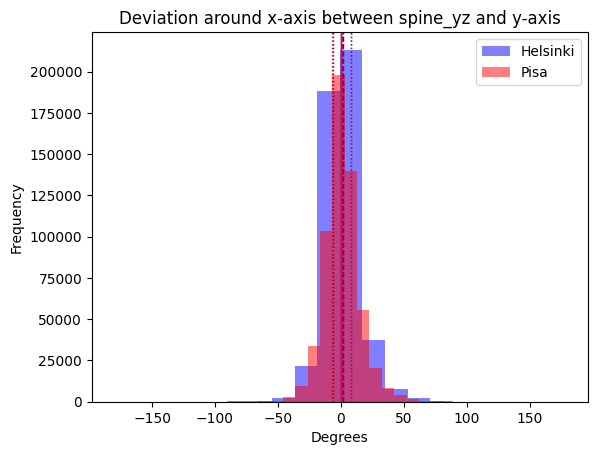

In [25]:
plot_histograms(helsinki_angles_x, pisa_angles_x, title='Deviation around x-axis between spine_yz and y-axis')

Helsinki Median: 0.18, Q1: -7.76, Q3: 8.12
Pisa Median: 0.28, Q1: -9.63, Q3: 11.91


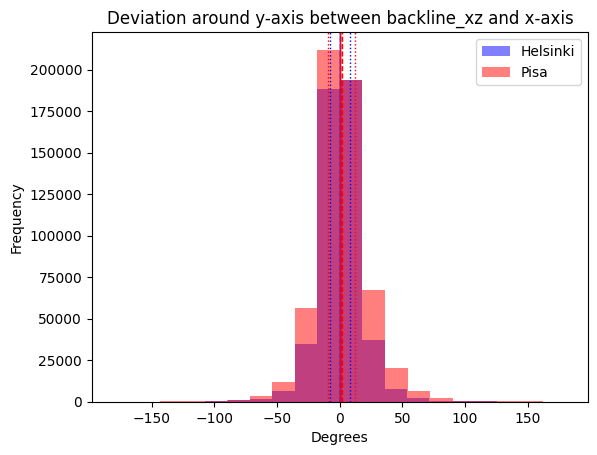

In [26]:
plot_histograms(helsinki_angles_y, pisa_angles_y, title='Deviation around y-axis between backline_xz and x-axis')

## Joint coordinates scatterplots

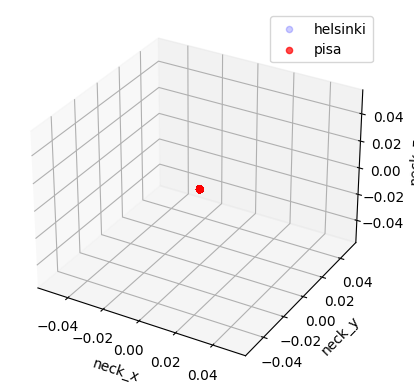

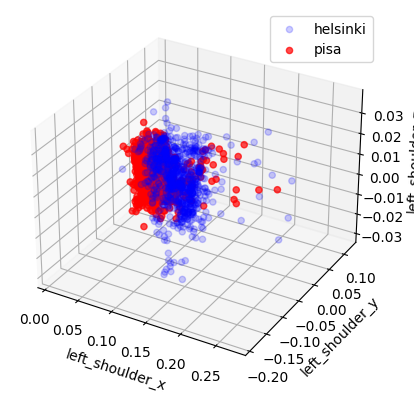

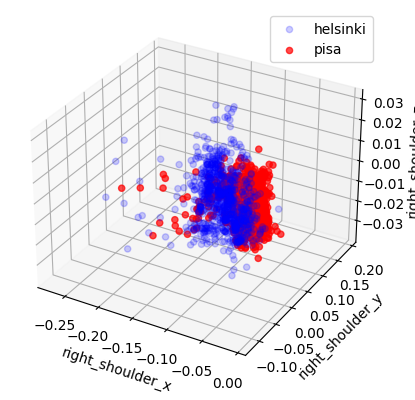

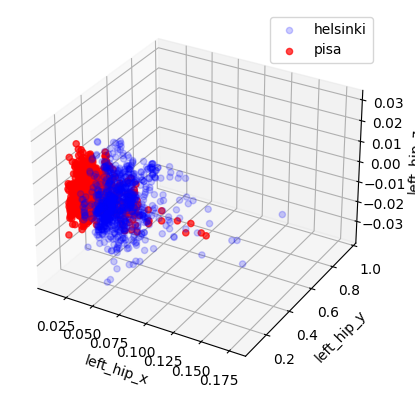

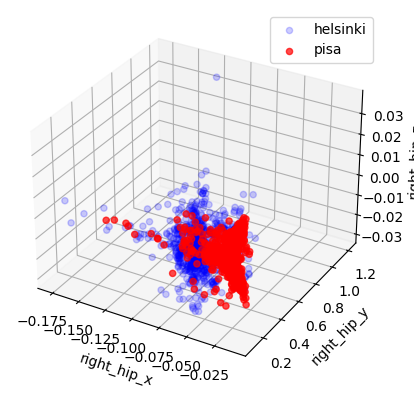

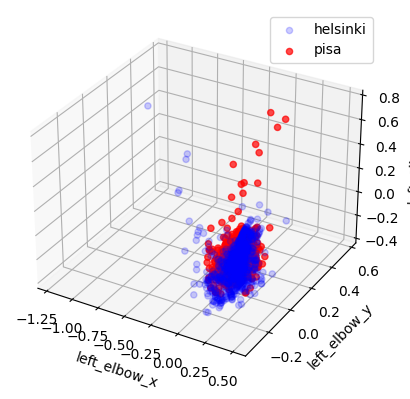

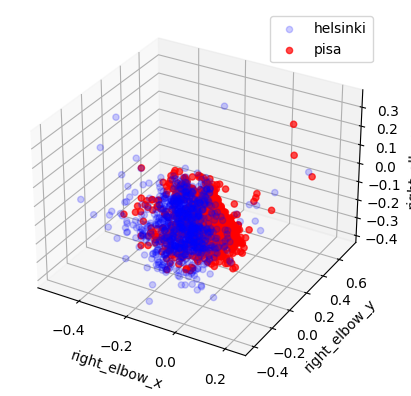

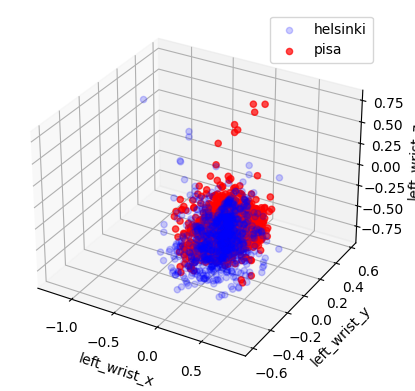

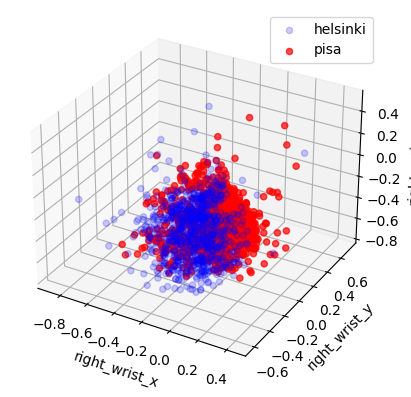

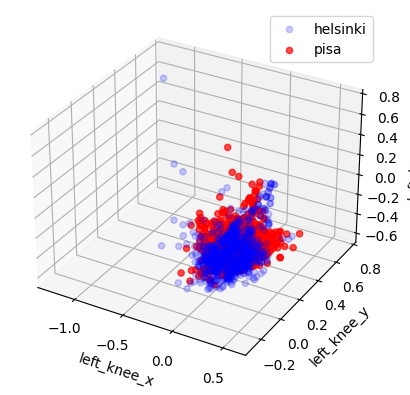

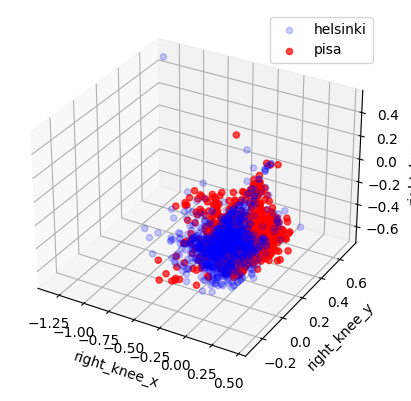

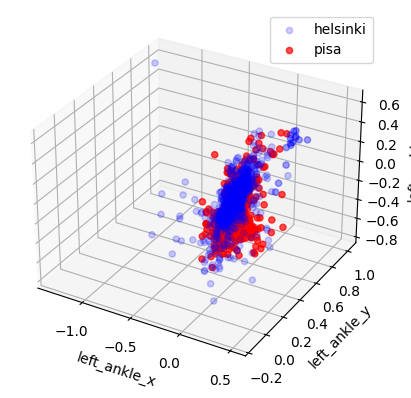

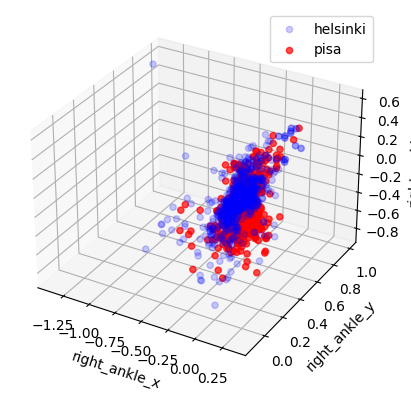

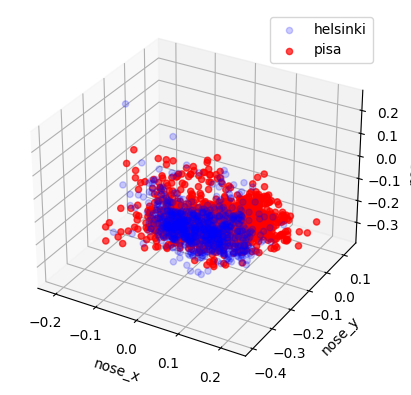

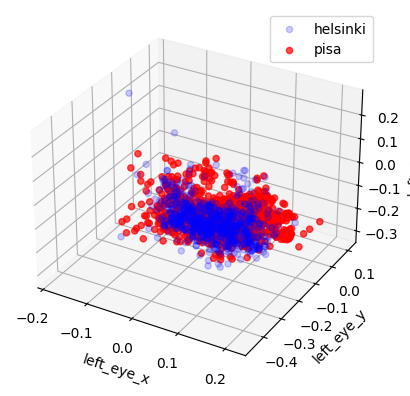

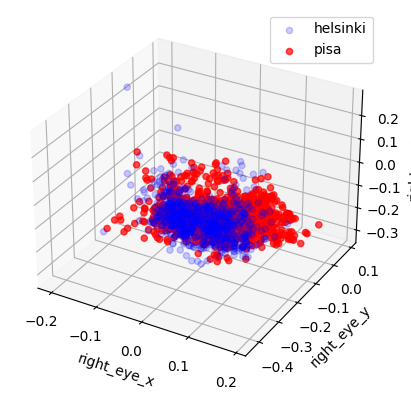

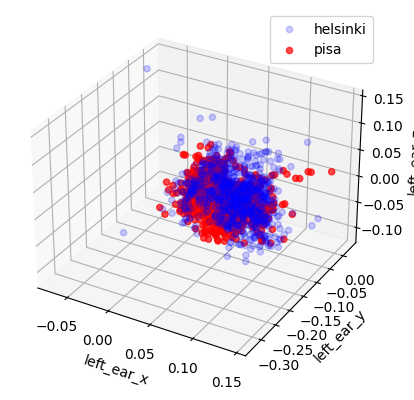

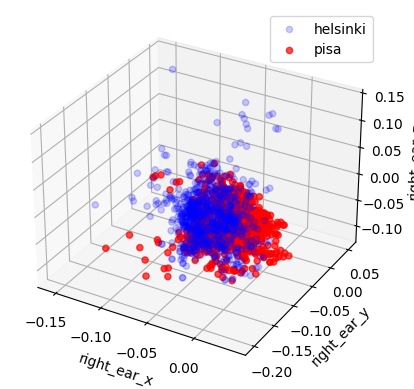

In [27]:
for bodypart in graph_bodyparts:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(helsinki_df[f'{bodypart}_x'], helsinki_df[f'{bodypart}_y'], helsinki_df[f'{bodypart}_z'], alpha=0.2, c='b', marker='o', label='helsinki')
    ax.scatter(pisa_df[f'{bodypart}_x'], pisa_df[f'{bodypart}_y'], pisa_df[f'{bodypart}_z'], alpha=0.7, c='r', marker='o', label='pisa')
    ax.set_xlabel(f'{bodypart}_x')
    ax.set_ylabel(f'{bodypart}_y')
    ax.set_zlabel(f'{bodypart}_z')
    plt.legend()
    plt.show()